# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part2 MNIST data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaeyoon Yoo, November 2017

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw a digit(MNIST data) given its label. <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load MNIST datasets
The MNIST datasets will be downloaded into the 'data' directory. If you want to change the directory the data is saved in, change mnist_data_dir with where you want. <br>

In [1]:
from download import *
import os
from utils import load_mnist
mnist_data_dir = './data'
prepare_data_dir(mnist_data_dir)
download_mnist(mnist_data_dir)
data_array , data_y = load_mnist(os.path.join(mnist_data_dir,'mnist'))
print(data_array.shape)
print(data_y.shape)

Found MNIST - skip
(70000, 28, 28, 1)
(70000, 10)


## <a name="1"></a> 1. Build a network

In this section, you will implement neural networks for (1) generative model to draw a digit (2) discriminative model to distinguish real image from generated image. You can use some function in *ops.py* or you can make it as you want. Just write the code in whatever way you find most clear.

In [2]:
from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

It is time for a generative model. It takes batch size, sample size(the dimension of latent variable or so called *noise*), y_dim(the dimension of label), the output size(should be 28 here) and z,y (Tensorflow Variables for latent variable and label respectively). It should return the image 28x28 output of which each element is in [0,1]. Note that you should define Tensorflow Variables within the variable scope.

You should utilize the label variable y in your model. The simplest way is concatenate the label variable and features or raw image.

In [21]:
def gern_net(batch_size, z , y ,sample_size, y_dim, output_size):
 #### TODO ####
    with tf.variable_scope('gen'):
        initializer = tf.contrib.layers.variance_scaling_initializer()
        y_extend = tf.reshape(y, shape=[-1,1,1,y_dim])
        #z_extend = tf.reshape(z, shape=[-1,-1,1,1])
        inputs = tf.concat(values=[z,y], axis=1)
        
        W1 = tf.get_variable("W1",[inputs.get_shape().as_list()[1],392],tf.float32,initializer=initializer)
        b1 = tf.Variable(tf.zeros((392)))
        layer1 = tf.nn.relu(batch_normal(fully_connect(inputs,W1,b1),scope="gen_full1"))
        
        inputs2 = tf.concat(values=[layer1, y], axis=1)
        W2 = tf.get_variable("W2",[inputs2.get_shape().as_list()[1],784],tf.float32,initializer)
        b2 = tf.Variable(tf.zeros((784)))
        layer2 = tf.nn.relu(batch_normal(fully_connect(inputs2,W2,b2),scope="gen_full2"))
        output = tf.reshape(layer2,[batch_size,output_size,output_size,1])

    return tf.nn.sigmoid(output)    


Now, it's time for a discriminative model. It takes image data and label variable y. It should return the value for which the model is certain that the image is real and its logit. (i.e return the value in [0,1] and its logit). Note that you should define Tensorflow Variables within the variable scope again.

You may use the label variable or not. Here, again concatenating is the simplest way to utilize it.

In [22]:
def dis_net(image_data , y, batch_size, reuse=False):
    with tf.variable_scope('dis',reuse=reuse):
        initializer=tf.contrib.layers.variance_scaling_initializer()
        image_data = tf.reshape(image_data,shape=[batch_size,-1])
        inputs = tf.concat([image_data,y], axis=1)
        
        W1 = tf.get_variable("W1",[inputs.get_shape().as_list()[1],392],tf.float32,initializer)
        b1 = tf.Variable(tf.zeros((392)))
        layer1 = lrelu(batch_normal(fully_connect(inputs,W1,b1),scope="dis_full1"))
        layer1 = tf.concat([layer1,y],axis=1)
        
        W2 = tf.get_variable("W2", [layer1.get_shape().as_list()[1],1], tf.float32, tf.contrib.layers.xavier_initializer())
        b2 = tf.Variable(tf.zeros((1)))
        output = fully_connect(layer1,W2,b2)
        
        #### TODO ####
    #### TODO ####
    return tf.nn.sigmoid(output) , output


## <a name="2"></a> 2. Build a main part and train it

In this section, you will implement the main part. You should define the loss function for each model(TODO part). Then run the code and check the model draws a digit for given label.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test' directory that resulting image will be saved in. You can change the directory as you want.

Also, you can change all other hyperparameters such as learning rate, batch size. But be sure to define **batch size bigger than 100**.

In [23]:
from utils import load_mnist
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

learning_rate = 0.0002
batch_size = 128
EPOCH = 15
loss_step    = 50
display_step = 50
sample_size = 100
y_dim = 10
channel = 1
output_size = 28
sample_dir = 'samples_for_test'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define the loss function in the TODO part. Modify only loss part.

Discriminator loss : log[D(x)] + log[1-D(G(z))]
Generator loss     : log[D(G(z)]

If you write the code correctly and run the code, it will display 10x10 images(each row shows one of the number). 

Also, it will save the generated images in the 'sample_dir' directory. So if you want to see it, check that directory.

**Please be sure that you ran the above codes**.

EPOCH 0 step 50: D: loss = 1.3712811 G: loss=0.7303275 
EPOCH 0 step 100: D: loss = 1.2922581 G: loss=0.7635212 
EPOCH 0 step 150: D: loss = 1.2404689 G: loss=0.7982440 
EPOCH 0 step 200: D: loss = 1.1760470 G: loss=0.8391746 
EPOCH 0 step 250: D: loss = 1.0839797 G: loss=0.8930532 
EPOCH 0 step 300: D: loss = 1.0422013 G: loss=0.9317310 
EPOCH 0 step 350: D: loss = 0.9660465 G: loss=0.9881917 
EPOCH 0 step 400: D: loss = 0.9153564 G: loss=1.0307899 
EPOCH 0 step 450: D: loss = 0.8643705 G: loss=1.0833969 
EPOCH 0 step 500: D: loss = 0.8255171 G: loss=1.1629431 


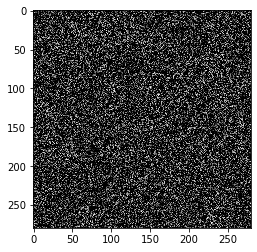

EPOCH 1 step 550: D: loss = 0.7553777 G: loss=1.2252414 
EPOCH 1 step 600: D: loss = 0.6808277 G: loss=1.2806573 
EPOCH 1 step 650: D: loss = 0.6414379 G: loss=1.3694534 
EPOCH 1 step 700: D: loss = 0.6278908 G: loss=1.4387932 
EPOCH 1 step 750: D: loss = 0.5388737 G: loss=1.4722642 
EPOCH 1 step 800: D: loss = 0.5239171 G: loss=1.5908661 
EPOCH 1 step 850: D: loss = 0.4660055 G: loss=1.6099381 
EPOCH 1 step 900: D: loss = 0.4504123 G: loss=1.7200153 
EPOCH 1 step 950: D: loss = 0.4168513 G: loss=1.8222030 
EPOCH 1 step 1000: D: loss = 0.4410318 G: loss=1.7910619 
EPOCH 1 step 1050: D: loss = 0.3881838 G: loss=1.9184346 


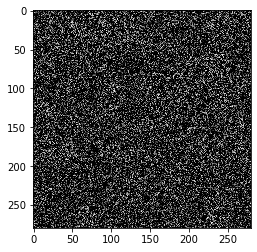

EPOCH 2 step 1100: D: loss = 0.3366469 G: loss=2.0160427 
EPOCH 2 step 1150: D: loss = 0.2915893 G: loss=2.0395050 
EPOCH 2 step 1200: D: loss = 0.3383536 G: loss=2.0277185 
EPOCH 2 step 1250: D: loss = 0.2913478 G: loss=2.1317089 
EPOCH 2 step 1300: D: loss = 0.3355362 G: loss=2.0368981 
EPOCH 2 step 1350: D: loss = 0.2583489 G: loss=2.1216416 
EPOCH 2 step 1400: D: loss = 0.2720327 G: loss=2.1081648 
EPOCH 2 step 1450: D: loss = 0.2390496 G: loss=2.1213021 
EPOCH 2 step 1500: D: loss = 0.2754554 G: loss=2.2683423 
EPOCH 2 step 1550: D: loss = 0.2304136 G: loss=2.1727228 
EPOCH 2 step 1600: D: loss = 0.2025976 G: loss=2.3470998 


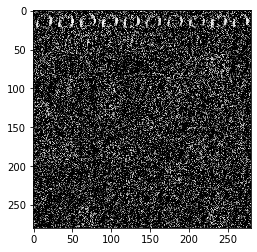

EPOCH 3 step 1650: D: loss = 0.2312344 G: loss=2.4391649 
EPOCH 3 step 1700: D: loss = 0.1974221 G: loss=2.3876576 
EPOCH 3 step 1750: D: loss = 0.2289094 G: loss=2.5208621 
EPOCH 3 step 1800: D: loss = 0.1969351 G: loss=2.5267260 
EPOCH 3 step 1850: D: loss = 0.1697378 G: loss=2.6132264 
EPOCH 3 step 1900: D: loss = 0.2030507 G: loss=2.5234427 
EPOCH 3 step 1950: D: loss = 0.1978073 G: loss=2.5552316 
EPOCH 3 step 2000: D: loss = 0.1973778 G: loss=2.6006248 
EPOCH 3 step 2050: D: loss = 0.1748984 G: loss=2.6958070 
EPOCH 3 step 2100: D: loss = 0.1255394 G: loss=2.8262830 
EPOCH 3 step 2150: D: loss = 0.1452653 G: loss=2.7820992 


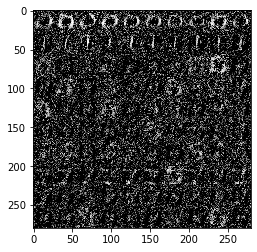

EPOCH 4 step 2200: D: loss = 0.1432084 G: loss=2.7346637 
EPOCH 4 step 2250: D: loss = 0.1523670 G: loss=2.7625885 
EPOCH 4 step 2300: D: loss = 0.1408386 G: loss=2.7638776 
EPOCH 4 step 2350: D: loss = 0.1279578 G: loss=2.8848381 
EPOCH 4 step 2400: D: loss = 0.1251741 G: loss=2.9274929 
EPOCH 4 step 2450: D: loss = 0.1306626 G: loss=2.9636083 
EPOCH 4 step 2500: D: loss = 0.1209716 G: loss=3.0822260 
EPOCH 4 step 2550: D: loss = 0.1575693 G: loss=2.9791174 
EPOCH 4 step 2600: D: loss = 0.1110922 G: loss=3.0960069 
EPOCH 4 step 2650: D: loss = 0.1013280 G: loss=3.2258747 
EPOCH 4 step 2700: D: loss = 0.1215045 G: loss=3.1003165 


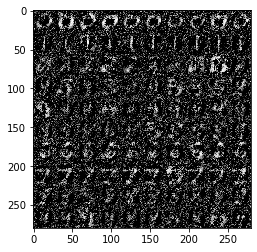

EPOCH 5 step 2750: D: loss = 0.1178103 G: loss=3.1866658 
EPOCH 5 step 2800: D: loss = 0.1131607 G: loss=3.2813668 
EPOCH 5 step 2850: D: loss = 0.1007477 G: loss=3.1213298 
EPOCH 5 step 2900: D: loss = 0.1125472 G: loss=3.2161453 
EPOCH 5 step 2950: D: loss = 0.1052261 G: loss=3.1590726 
EPOCH 5 step 3000: D: loss = 0.1056608 G: loss=3.0446708 
EPOCH 5 step 3050: D: loss = 0.1177514 G: loss=3.0118361 
EPOCH 5 step 3100: D: loss = 0.1016789 G: loss=3.3833511 
EPOCH 5 step 3150: D: loss = 0.0860995 G: loss=3.2210779 
EPOCH 5 step 3200: D: loss = 0.0892292 G: loss=3.3459969 
EPOCH 5 step 3250: D: loss = 0.1197139 G: loss=3.3050396 


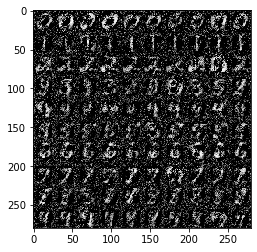

EPOCH 6 step 3300: D: loss = 0.1014900 G: loss=3.4268532 
EPOCH 6 step 3350: D: loss = 0.1119264 G: loss=3.3666978 
EPOCH 6 step 3400: D: loss = 0.0999387 G: loss=3.1521001 
EPOCH 6 step 3450: D: loss = 0.0903968 G: loss=3.6153054 
EPOCH 6 step 3500: D: loss = 0.0887663 G: loss=3.3093672 
EPOCH 6 step 3550: D: loss = 0.0692278 G: loss=3.5713742 
EPOCH 6 step 3600: D: loss = 0.1055906 G: loss=3.5460982 
EPOCH 6 step 3650: D: loss = 0.0841828 G: loss=3.3965840 
EPOCH 6 step 3700: D: loss = 0.0587792 G: loss=3.7122824 
EPOCH 6 step 3750: D: loss = 0.1008892 G: loss=3.2013125 
EPOCH 6 step 3800: D: loss = 0.0747123 G: loss=3.3972466 


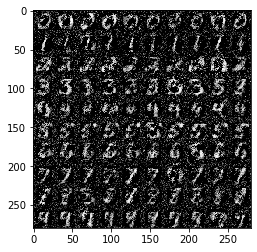

EPOCH 7 step 3850: D: loss = 0.0640827 G: loss=3.6058402 
EPOCH 7 step 3900: D: loss = 0.0733646 G: loss=3.4555211 
EPOCH 7 step 3950: D: loss = 0.0649545 G: loss=3.5534372 
EPOCH 7 step 4000: D: loss = 0.0809404 G: loss=3.1810164 
EPOCH 7 step 4050: D: loss = 0.0789179 G: loss=3.5698290 
EPOCH 7 step 4100: D: loss = 0.0701240 G: loss=3.4478989 
EPOCH 7 step 4150: D: loss = 0.0796672 G: loss=3.4941368 
EPOCH 7 step 4200: D: loss = 0.0698362 G: loss=3.6763475 
EPOCH 7 step 4250: D: loss = 0.0841692 G: loss=3.4395692 
EPOCH 7 step 4300: D: loss = 0.0811373 G: loss=3.6002483 
EPOCH 7 step 4350: D: loss = 0.0701862 G: loss=3.5953929 


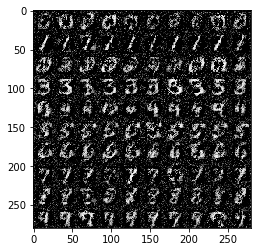

EPOCH 8 step 4400: D: loss = 0.0668150 G: loss=3.7017186 
EPOCH 8 step 4450: D: loss = 0.0506664 G: loss=3.9865327 
EPOCH 8 step 4500: D: loss = 0.0668402 G: loss=3.9350781 
EPOCH 8 step 4550: D: loss = 0.0509631 G: loss=3.9496155 
EPOCH 8 step 4600: D: loss = 0.0639206 G: loss=3.8369935 
EPOCH 8 step 4650: D: loss = 0.0689873 G: loss=3.9144835 
EPOCH 8 step 4700: D: loss = 0.0662983 G: loss=3.7417645 
EPOCH 8 step 4750: D: loss = 0.0621061 G: loss=3.6465244 
EPOCH 8 step 4800: D: loss = 0.0584356 G: loss=4.1429090 
EPOCH 8 step 4850: D: loss = 0.0605531 G: loss=3.9734221 
EPOCH 8 step 4900: D: loss = 0.0528336 G: loss=3.9508576 


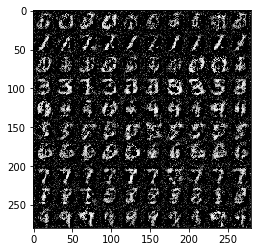

EPOCH 9 step 4950: D: loss = 0.0591415 G: loss=3.7862053 
EPOCH 9 step 5000: D: loss = 0.0551215 G: loss=3.8791623 
EPOCH 9 step 5050: D: loss = 0.0442272 G: loss=4.1659861 
EPOCH 9 step 5100: D: loss = 0.0542989 G: loss=4.1560230 
EPOCH 9 step 5150: D: loss = 0.0512432 G: loss=3.9771683 
EPOCH 9 step 5200: D: loss = 0.0390806 G: loss=4.2521415 
EPOCH 9 step 5250: D: loss = 0.0379417 G: loss=4.3149023 
EPOCH 9 step 5300: D: loss = 0.0479895 G: loss=4.1193361 
EPOCH 9 step 5350: D: loss = 0.0375659 G: loss=4.0961103 
EPOCH 9 step 5400: D: loss = 0.0383546 G: loss=3.9669061 
EPOCH 9 step 5450: D: loss = 0.0354368 G: loss=4.2736301 


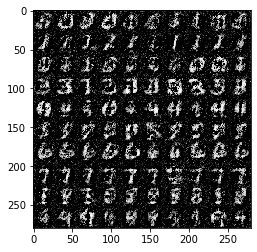

EPOCH 10 step 5500: D: loss = 0.0305201 G: loss=4.4546423 
EPOCH 10 step 5550: D: loss = 0.0297763 G: loss=4.5255899 
EPOCH 10 step 5600: D: loss = 0.0350796 G: loss=4.4462109 
EPOCH 10 step 5650: D: loss = 0.0273304 G: loss=4.6656899 
EPOCH 10 step 5700: D: loss = 0.0392162 G: loss=4.3399110 
EPOCH 10 step 5750: D: loss = 0.0295591 G: loss=4.4605184 
EPOCH 10 step 5800: D: loss = 0.0398535 G: loss=4.2578478 
EPOCH 10 step 5850: D: loss = 0.0289999 G: loss=4.4746666 
EPOCH 10 step 5900: D: loss = 0.0294301 G: loss=4.4765229 
EPOCH 10 step 5950: D: loss = 0.0343242 G: loss=4.5480361 
EPOCH 10 step 6000: D: loss = 0.0261296 G: loss=4.5769591 


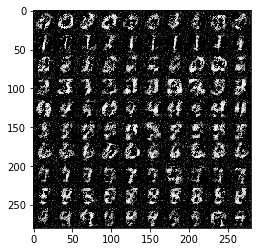

EPOCH 11 step 6050: D: loss = 0.0303672 G: loss=4.3671980 
EPOCH 11 step 6100: D: loss = 0.0319768 G: loss=4.4688034 
EPOCH 11 step 6150: D: loss = 0.0282556 G: loss=4.3516006 
EPOCH 11 step 6200: D: loss = 0.0345778 G: loss=4.4556227 
EPOCH 11 step 6250: D: loss = 0.0264698 G: loss=4.5724554 
EPOCH 11 step 6300: D: loss = 0.0444675 G: loss=4.5857992 
EPOCH 11 step 6350: D: loss = 0.0243077 G: loss=4.5864391 
EPOCH 11 step 6400: D: loss = 0.0272806 G: loss=4.5390730 
EPOCH 11 step 6450: D: loss = 0.0288332 G: loss=4.9390922 
EPOCH 11 step 6500: D: loss = 0.0244159 G: loss=4.7800217 
EPOCH 11 step 6550: D: loss = 0.0277473 G: loss=4.7824950 


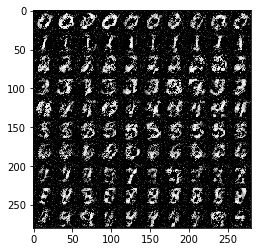

EPOCH 12 step 6600: D: loss = 0.0246070 G: loss=4.8342180 
EPOCH 12 step 6650: D: loss = 0.0229123 G: loss=4.8015757 
EPOCH 12 step 6700: D: loss = 0.0245430 G: loss=4.5227957 
EPOCH 12 step 6750: D: loss = 0.0257497 G: loss=4.5276051 
EPOCH 12 step 6800: D: loss = 0.0277056 G: loss=4.8076944 
EPOCH 12 step 6850: D: loss = 0.0285658 G: loss=4.6698170 
EPOCH 12 step 6900: D: loss = 0.0308966 G: loss=4.2566509 
EPOCH 12 step 6950: D: loss = 0.0239217 G: loss=4.4849539 
EPOCH 12 step 7000: D: loss = 0.0250612 G: loss=4.9437776 
EPOCH 12 step 7050: D: loss = 0.0257903 G: loss=5.0765944 


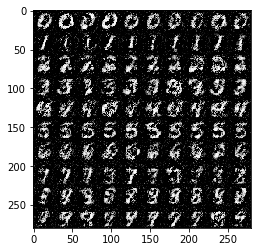

EPOCH 13 step 7100: D: loss = 0.0231526 G: loss=4.7560401 
EPOCH 13 step 7150: D: loss = 0.0214700 G: loss=4.9220810 
EPOCH 13 step 7200: D: loss = 0.0191408 G: loss=5.1405611 
EPOCH 13 step 7250: D: loss = 0.0185793 G: loss=5.1213822 
EPOCH 13 step 7300: D: loss = 0.0243529 G: loss=5.1932759 
EPOCH 13 step 7350: D: loss = 0.0189431 G: loss=5.0160027 
EPOCH 13 step 7400: D: loss = 0.0182672 G: loss=5.2250228 
EPOCH 13 step 7450: D: loss = 0.0176856 G: loss=5.2364244 
EPOCH 13 step 7500: D: loss = 0.0162099 G: loss=5.2384052 
EPOCH 13 step 7550: D: loss = 0.0202209 G: loss=4.8713012 
EPOCH 13 step 7600: D: loss = 0.0163705 G: loss=5.2168531 


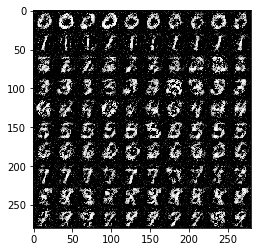

EPOCH 14 step 7650: D: loss = 0.0171187 G: loss=4.8950057 
EPOCH 14 step 7700: D: loss = 0.0226112 G: loss=5.0850658 
EPOCH 14 step 7750: D: loss = 0.0215691 G: loss=5.0413752 
EPOCH 14 step 7800: D: loss = 0.0157350 G: loss=5.0396261 
EPOCH 14 step 7850: D: loss = 0.0221633 G: loss=5.1579099 
EPOCH 14 step 7900: D: loss = 0.0129191 G: loss=5.1939125 
EPOCH 14 step 7950: D: loss = 0.0160327 G: loss=5.3194799 
EPOCH 14 step 8000: D: loss = 0.0150199 G: loss=5.2441058 
EPOCH 14 step 8050: D: loss = 0.0156809 G: loss=5.1576691 
EPOCH 14 step 8100: D: loss = 0.0115133 G: loss=5.3879461 
EPOCH 14 step 8150: D: loss = 0.0122828 G: loss=5.5267868 


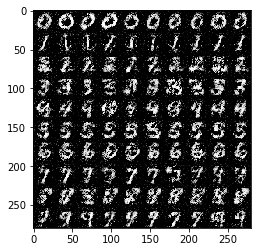

EPOCH 15 step 8200: D: loss = 0.0139916 G: loss=5.4861717 
EPOCH 15 step 8250: D: loss = 0.0121954 G: loss=5.4280653 
EPOCH 15 step 8300: D: loss = 0.0124268 G: loss=5.6331682 
EPOCH 15 step 8350: D: loss = 0.0125787 G: loss=5.7710900 
EPOCH 15 step 8400: D: loss = 0.0135475 G: loss=5.1537981 
EPOCH 15 step 8450: D: loss = 0.0189540 G: loss=5.2110014 
EPOCH 15 step 8500: D: loss = 0.0123844 G: loss=5.3593469 
EPOCH 15 step 8550: D: loss = 0.0132705 G: loss=5.8168507 
EPOCH 15 step 8600: D: loss = 0.0111185 G: loss=5.4725385 
EPOCH 15 step 8650: D: loss = 0.0116874 G: loss=5.5551243 
EPOCH 15 step 8700: D: loss = 0.0123830 G: loss=5.1980486 


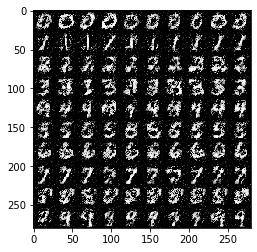

In [24]:
tf.reset_default_graph()

sample_z = np.random.uniform(-1 , 1 , size = [batch_size , sample_size])

y = tf.placeholder(tf.float32, [None , y_dim])

images = tf.placeholder(tf.float32, [batch_size, output_size, output_size, channel])

z = tf.placeholder(tf.float32, [None , sample_size])

fake_images = gern_net(batch_size, z , y ,sample_size, y_dim,output_size)

##the loss of gerenate network
D_pro , D_logits = dis_net(images, y , batch_size, False)

G_pro, G_logits = dis_net(fake_images , y , batch_size, True)

#### TODO ####
# DEFINE LOSS FUNCTION #

D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(G_pro),logits=G_logits)) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_pro),logits=D_logits))
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(G_pro),logits=G_logits))

#############

t_vars = tf.trainable_variables()

d_var = [var for var in t_vars if 'dis' in var.name]
g_var = [var for var in t_vars if 'gen' in var.name]

opti_D = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(D_loss , var_list=d_var)
opti_G = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(G_loss , var_list=g_var)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:

    sess.run(init)
    e = 0
    step = 0

    while e <= EPOCH:
        batch_num = 0
        while batch_num < len(data_array) / batch_size - 1:

            step = step + 1

            realbatch_array , real_labels = getNext_batch(data_array , data_y , batch_num, batch_size)
            
            #Get the z
            batch_z = np.random.uniform(-1 , 1 , size=[batch_size , sample_size])

            _ = sess.run(opti_D, feed_dict={images:realbatch_array, z:batch_z , y:real_labels})
            _ = sess.run(opti_G, feed_dict={z: batch_z , y:real_labels})

            batch_num += 1

            if step % loss_step == 0:

                d_get_loss = sess.run(D_loss , feed_dict = {images:realbatch_array , z:batch_z , y:real_labels})
                g_get_loss = sess.run(G_loss , feed_dict = {z: batch_z , y:real_labels})
                print("EPOCH %d step %d: D: loss = %.7f G: loss=%.7f " % (e , step , d_get_loss , g_get_loss))

            if np.mod(step , display_step) == 1:

                sample_images = sess.run(fake_images , feed_dict={z:sample_z , y:sample_label(batch_size)})
                sample_images = sample_images[:100,:,:,:]
                image_name = './{}/train_{:02d}_{:04d}.png'.format(sample_dir , e , step)
                save_images(sample_images , [10,10] , image_name)

        img = mpimg.imread(image_name)
        imgplot = plt.imshow(img)
        plt.show()

        e = e + 1
        batch_num = 0
